In [ ]:
import pandas as pd

df = pd.read_csv('dataset/in.tsv', sep='\t')
df.columns = ["file_name", "list_keys", "pdf2djvu/djvu2hocr", "tesseract", "textract", "pdf2djvu/djvu2hocr_tesseract"]
df = df.dropna(axis = 0)

In [63]:
# Choose which extracted text method to use as input
documents = df["tesseract"].tolist()

In [89]:
# Treatment of cleaned text: tokenisation, stemming and lemmatisation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pickle
from rich.progress import track

def cleaning(document):
    # Load English tokenizer, tagger, parser and NER
    nlp = spacy.load("en_core_web_sm")
    # Process whole documents
    document = document.replace("\\n"," ")
    doc = nlp(document)

    # Tokenisation
    token_list = []
    for token in doc:
        token_list.append(token.text)

    # Create list of word tokens after removing stopwords
    filtered_sentence =[] 

    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
            
    doc = nlp(' '.join(filtered_sentence))

    #Lematization
    lemma_word = [] 
    for token in doc:
        lemma_word.append(token.lemma_)

    #Remove punctuation
    doc = ' '.join(word.strip(string.punctuation) for word in lemma_word)

    return doc

# Call of the function for all documents
# in_documents = [cleaning(document) for document in documents]

In [90]:
# import pickle
# with open('in_documents.pkl', 'wb') as f:
#     pickle.dump(in_documents, f)

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

with open('in_documents.pkl', 'rb') as f:
    in_documents = pickle.load(f)

vectorizer = TfidfVectorizer(stop_words='english')
trans = vectorizer.fit_transform(in_documents) # input must be a list of string aka whole text in one str

svd = TruncatedSVD(100)
X = svd.fit_transform(trans)

true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()


<AxesSubplot:>

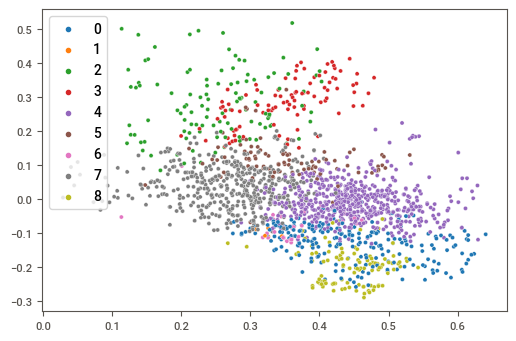

In [112]:
import seaborn as sns

x = X[:,0]
y = X[:,1]
df = pd.DataFrame({'x': x,'y': y, 'model': model.labels_})

sns.scatterplot(x=x, y=y, hue=model.labels_, palette='tab10')

In [101]:
df = pd.DataFrame(model.labels_)
df.value_counts()

6    669
3    368
7    273
8    113
2    106
1    101
4     30
5     17
0      5
dtype: int64